In [15]:
from mcmc import line
from mcmc.utils import plot_chain, plot_corner
from matplotlib import pyplot as plt
import numpy as np
from time import time

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [3]:
plt.style.use('seaborn-v0_8-talk') # I personally prefer seaborn for the graph style, but you may choose whichever you want.
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern"]}
plt.rcParams.update(params)

In [4]:
m_true = -0.9594
b_true = 4.294
f_true = 0.423

v_true = [m_true, b_true, f_true]

data = line.generate_data(50, v_true)
data.shape

(3, 50)

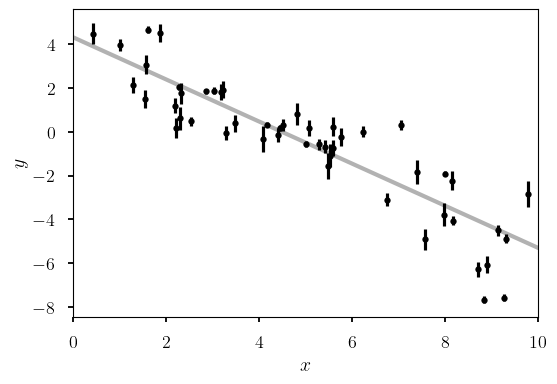

In [5]:
x = data[0]
y = data[1]
yerr = data[2]

# Plot the data
plt.figure(figsize=(6, 4))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [6]:
locs = v_true
scales = [0.6, 3, 2]
locs = [np.arctan(m_true)-scales[0]/2, b_true-scales[1]/2, np.log(f_true)-scales[2]/2]

ndim = 3
nwalkers = 16

p0 = line.generate_p0(nwalkers, locs, scales)
p0.shape

(16, 3)

In [7]:
p0.shape, data.shape

((16, 3), (3, 50))

In [8]:
line.log_prob(p0, data, locs, scales)

array([ -130.19042813,  -143.48293008,  -124.53708398,  -161.5064575 ,
         -45.1673591 ,  -393.79035329, -1927.34709628,  -210.59120857,
        -458.95978523,  -187.48955508,  -455.06272662,   -36.97272326,
        -704.38363251,  -333.36606704,  -124.02288531,  -276.35323429])

# Affine invariant

In [17]:
t0 = time()
chain = line.run_mcmc(50000, nwalkers, p0, data, locs, scales, verbose=True, batch=4, parallel=True)
# chain = af.mcmc_line(500, nwalkers, p0, data, verbose=True)
t1 = time()
print(f"Time taken: {t1-t0} s")

Acceptance rate: 0.64502
Time taken: 5.190585613250732 s


In [26]:
t0 = time()
# chain = af.mcmc_line(500, nwalkers, p0, data, verbose=True, batch=2, parallel=True)
chain = line.run_mcmc(1000, nwalkers, p0, data, locs, scales, verbose=True)
t1 = time()
print(f"Time taken: {t1-t0} s")

Time taken: 0.17018795013427734 s
Acceptance rate: 0.6514375


100%|██████████| 1000/1000 [00:00<00:00, 5910.16it/s]

In [ ]:
# %%timeit -n 3 -r 5

# chain = MCMC.run_mcmc(1000, 20, parallel=True)

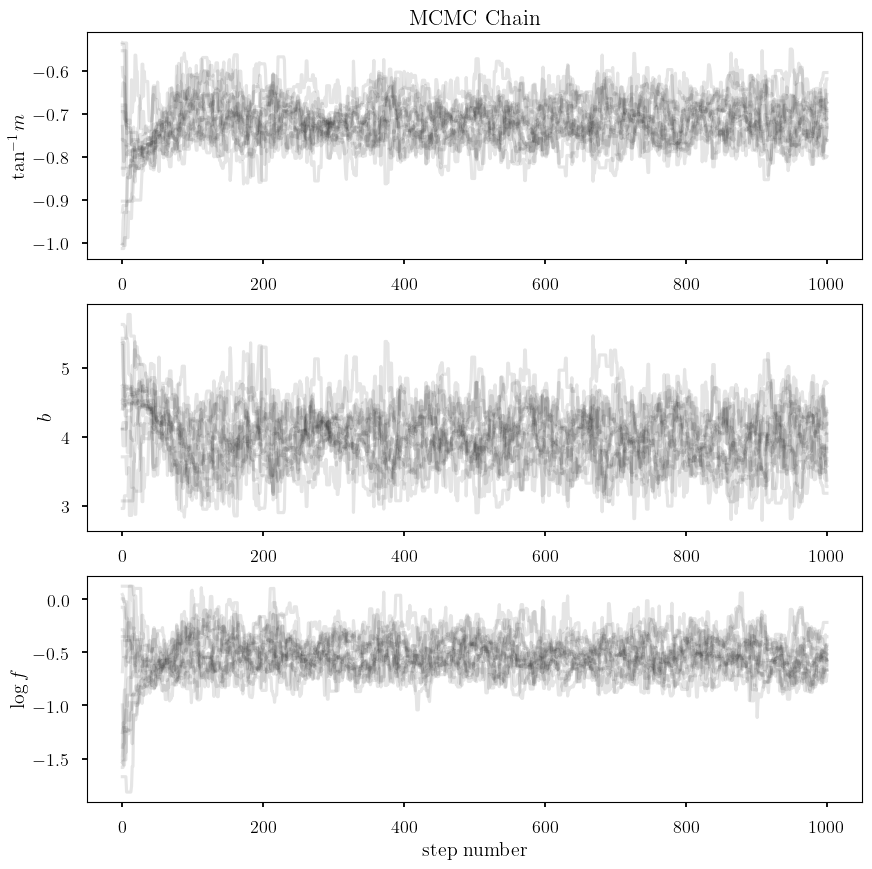

In [27]:
# plot the chain
labels = [r"$\tan^{-1} m$", r"$b$", r"$\log f$"]
plot_chain(chain, labels)

In [28]:
p0_next = chain[-1]
t0 = time()
chain = line.run_mcmc(50000, nwalkers, p0_next, data, locs, scales, verbose=True)
t1 = time()
print(f"Time taken: {t1-t0} s")

Acceptance rate: 0.653175
Time taken: 6.790000915527344 s


 22%|██▍       | 10824/50000 [00:01<00:05, 7214.12it/s]

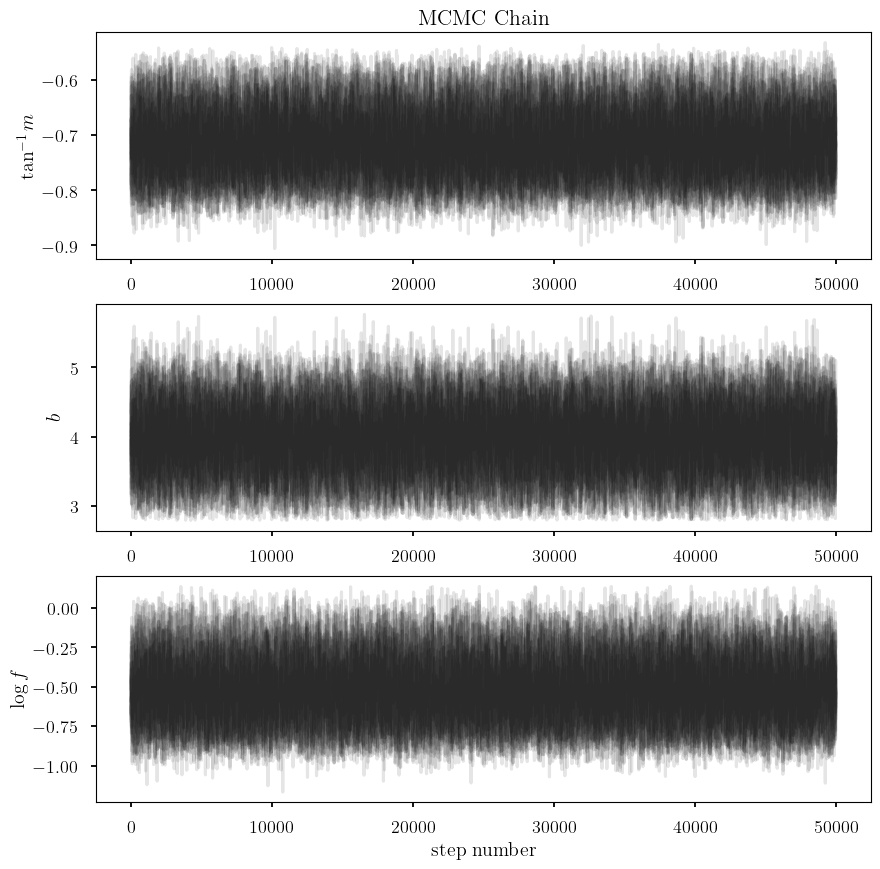

In [29]:
# plot the chain
labels = [r"$\tan^{-1} m$", r"$b$", r"$\log f$"]
plot_chain(chain, labels)

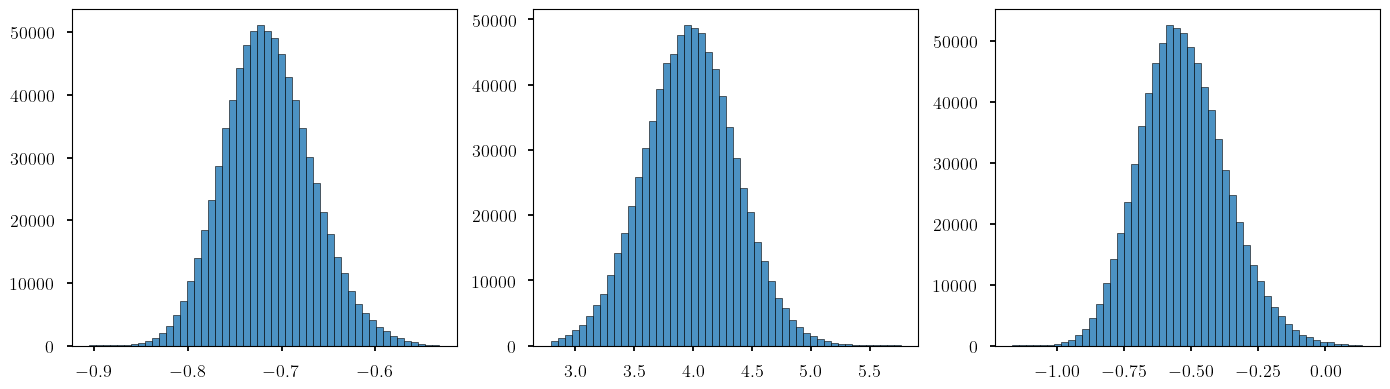

In [30]:
# plot in subplots
flat = chain.reshape((-1, 3)).copy()
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    axes[i].hist(flat[:, i], bins=50, histtype="bar", alpha=0.8, ec="k", lw=0.5)
fig.tight_layout()
plt.show()


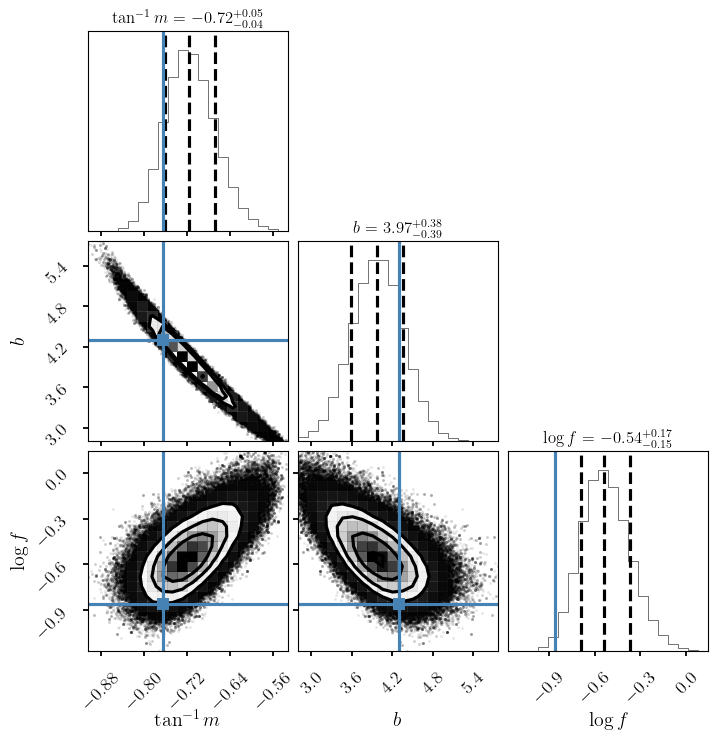

In [31]:
truths = [np.arctan(m_true), b_true, np.log(f_true)]

plot_corner(chain, labels, truths=truths)

# emcee

In [9]:
from multiprocessing import Pool
import os
import emcee
os.environ["OMP_NUM_THREADS"] = "8"

In [10]:
line.log_prob(p0, data, locs, scales)

array([ -130.19042813,  -143.48293008,  -124.53708398,  -161.5064575 ,
         -45.1673591 ,  -393.79035329, -1927.34709628,  -210.59120857,
        -458.95978523,  -187.48955508,  -455.06272662,   -36.97272326,
        -704.38363251,  -333.36606704,  -124.02288531,  -276.35323429])

In [11]:
def log_prob(theta, data, locs, scales):
    return line.log_prob(np.array([theta]), data, locs, scales)

In [12]:
# %%timeit

t0 = time()
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, args=(data, locs, scales), pool=pool
    )
    sampler.run_mcmc(p0, 1000, progress=True)
t1 = time()
print(f"Time taken: {t1-t0} s")

100%|██████████| 1000/1000 [00:06<00:00, 155.59it/s]

Time taken: 6.646012306213379 s


In [13]:
chain = sampler.get_chain()
print(chain.shape)

(1000, 16, 3)


(1000, 16, 3)


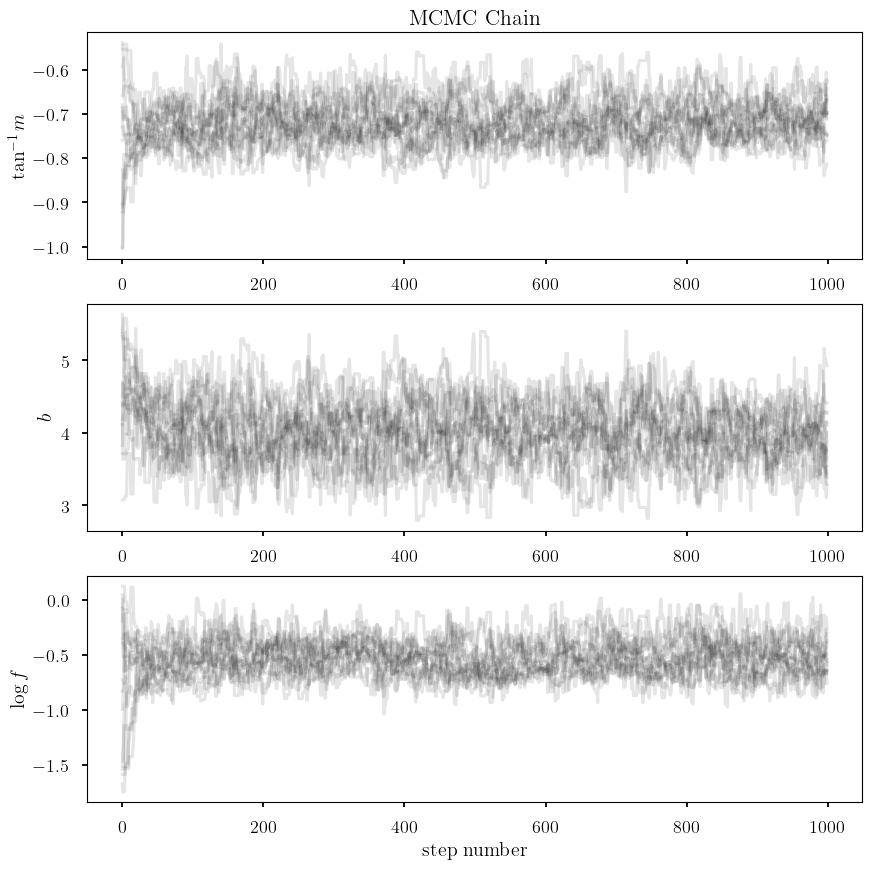

In [18]:
chain = sampler.get_chain()
print(chain.shape)
labels = [r"$\tan^{-1} m$", r"$b$", r"$\log f$"]
plot_chain(chain, labels)

In [19]:
p0_next = chain[-1]

t0 = time()
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, args=(data, locs, scales), pool=pool
    )
    sampler.run_mcmc(p0_next, 5000, progress=True)
t1 = time()
print(f"Time taken: {t1-t0} s")

100%|██████████| 5000/5000 [00:26<00:00, 187.26it/s]

Time taken: 26.972421646118164 s


(5000, 16, 3)


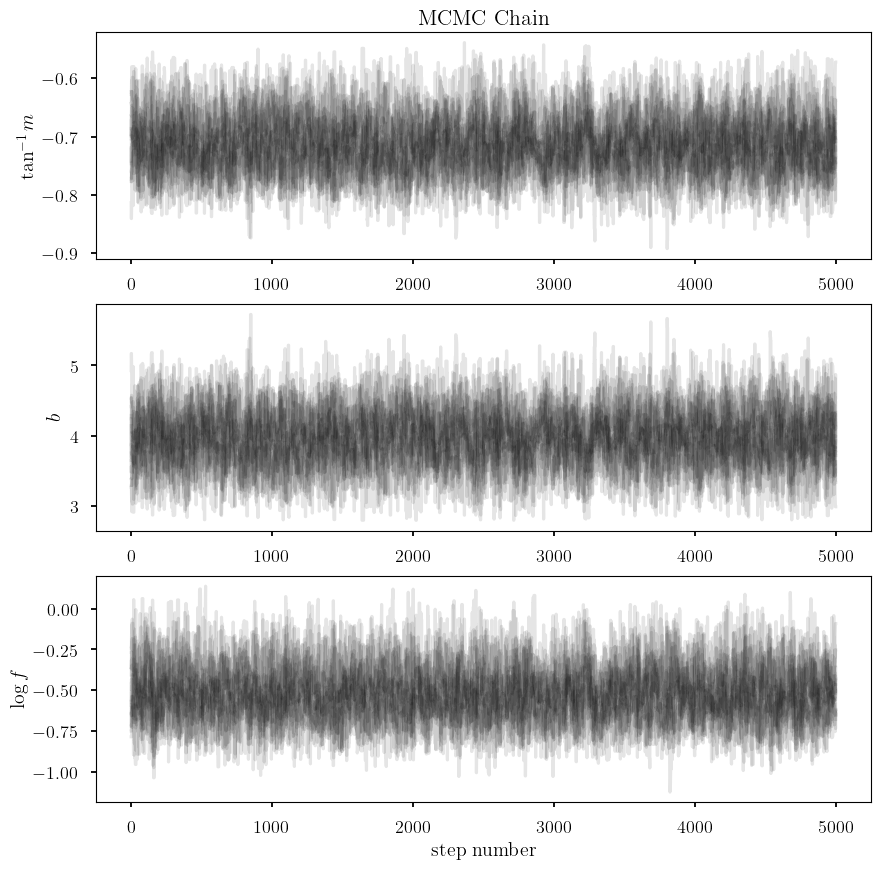

In [20]:
chain = sampler.get_chain()
print(chain.shape)
plot_chain(chain, labels)

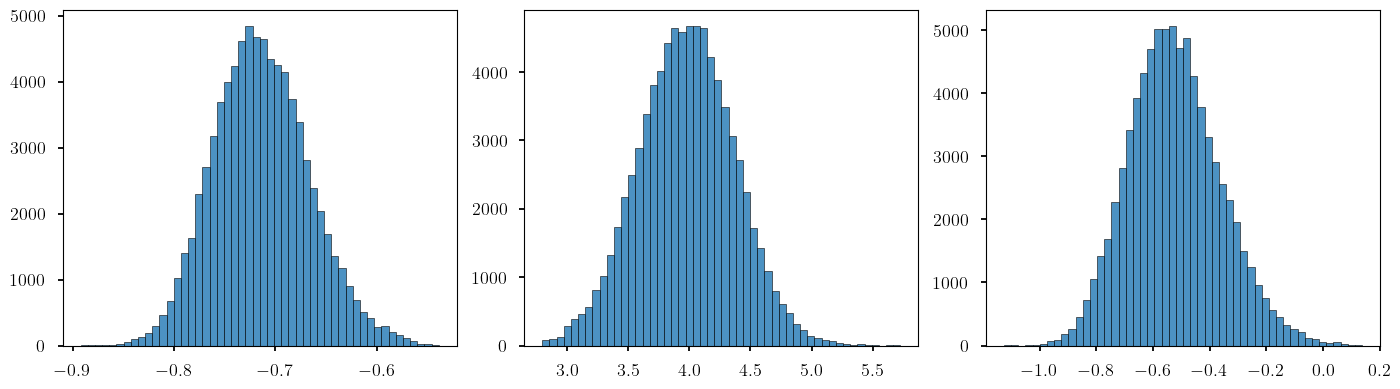

In [22]:
# plot in subplots
flat = chain.reshape((-1, 3)).copy()
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    axes[i].hist(flat[:, i], bins=50, histtype="bar", alpha=0.8, ec="k", lw=0.5)
fig.tight_layout()
plt.show()


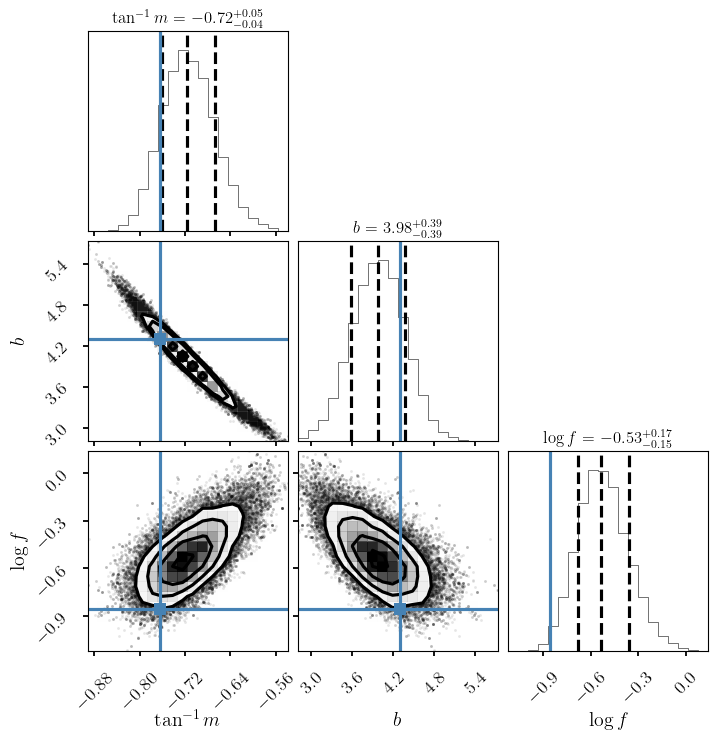

In [23]:
truths = [np.arctan(m_true), b_true, np.log(f_true)]

plot_corner(chain, labels, truths=truths)